In [43]:
BASE_PROJECT_DIR = '/home/akhanal1/ature'
BASE_PROJECT_DIR = '/home/ak/PycharmProjects/ature'

import os
import sys
import traceback

sys.path.append(BASE_PROJECT_DIR)
os.chdir(BASE_PROJECT_DIR)

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from utils import img_utils as iu
sep = os.sep
import torch
import math
%load_ext autoreload
%autoreload 2
from PIL import Image as IMG
import utils.img_utils as iu
from commons.IMAGE import Image
import json
from skimage.morphology import skeletonize_3d
from scipy.ndimage.measurements import label

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import neuralnet.utils.auto_split as asp
from neuralnet.utils.measurements import get_best_thr

from neuralnet.unet.runs import DRIVE as unetDRIVE
from neuralnet.thrnet.runs import DRIVE32a as DRIVE32
from neuralnet.unet.runs import DRIVE
import operator

In [130]:
split_file = DRIVE32['Dirs']['logs'] + os.sep + DRIVE32['Params']['checkpoint_file'] + '.json'
split = json.load(open(split_file))

unet_split_file = split_file = DRIVE['Dirs']['logs'] + os.sep + DRIVE['Params']['checkpoint_file'] + '.json'
usplit = json.load(open(unet_split_file))
checks = [110, 115, 120, 125, 130]
f1 = {110:0,115:0, 120:0, 125:0, 130:0}

In [131]:
for file in usplit['test']:
    imap = Image()
    imap.load_file(DRIVE32['Dirs']['image'],  file.split('.')[0]+'.png')
    imap.working_arr = imap.image_arr
    imap.load_ground_truth(DRIVE32['Dirs']['truth'], DRIVE32['Funcs']['truth_getter'])
    imap.load_mask(DRIVE32['Dirs']['mask'], DRIVE32['Funcs']['mask_getter'])
    imap.apply_mask()
    for th in checks:
        ig = imap.working_arr.copy()
        ig[ig>th] = 255
        ig[ig<=th] = 0
        prf1a =  iu.get_praf1(ig, imap.ground_truth)
#         print(prf1a)
        f1[th] += prf1a['F1']

In [133]:
f1[125]/10

0.823198

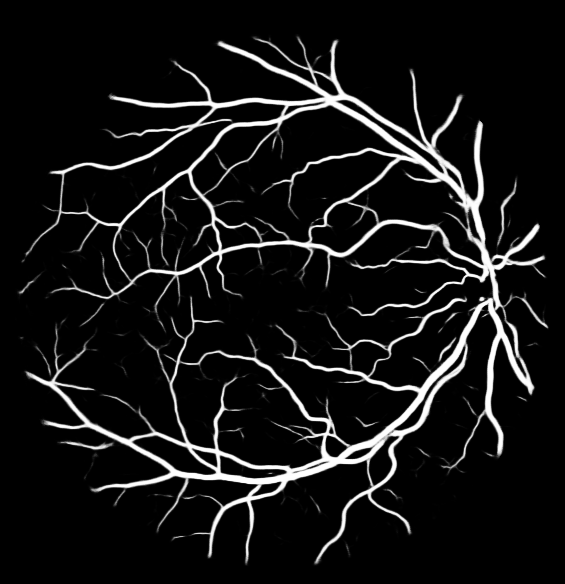

In [65]:
IMG.fromarray(imap.working_arr)

In [31]:
def get_prf1a_for_patch(img_obj, shape):
    indices = iu.get_chunk_indexes(img_obj.working_arr.shape, shape, shape)
    thrp = np.zeros_like(img_obj.working_arr.copy())
    for p, q, r, s in indices:
        patch = img_obj.working_arr[p:q,r:s].copy()
        y = img_obj.ground_truth[p:q, r:s].copy()
        t = get_best_thr(patch, y)[1] 
        patch[patch>t] = 255
        patch[patch<=t] = 0
        thrp[p:q,r:s] = patch
    thrp[img_obj.mask==0]=0
    return iu.get_praf1(thrp, img_obj.ground_truth)

### Compute global best thr, per image thr and per patch thr

In [135]:
header = ['FILE','UNET_PRED','GLOBAL_THR','PER_IMG_THR','PATCH16_THR','PATCH32_THR','PATCH64_THR']
f1_data = []
prec_data = []
rec_data = []
acc_data = []
for file in usplit['test']:
    imap = Image()
    imap.load_file(DRIVE32['Dirs']['image'],  file.split('.')[0]+'.png')
    imap.working_arr = imap.image_arr
    imap.load_ground_truth(DRIVE32['Dirs']['truth'], DRIVE32['Funcs']['truth_getter'])
    imap.load_mask(DRIVE32['Dirs']['mask'], DRIVE32['Funcs']['mask_getter'])
    imap.apply_mask()
    
    unet_img = iu.get_image_as_array(image_file='data/DRIVE/unet_logs_pred/'+file.split('.')[0]+'.png', channels=1)
    unet_pred = iu.get_praf1(unet_img, imap.ground_truth)
    
    ig = imap.working_arr.copy()
    ig[ig>108] = 255
    ig[ig<=108] = 0
    global_thr =  iu.get_praf1(ig, imap.ground_truth)
    
    per_img = get_best_thr(imap.working_arr.copy(), imap.ground_truth)[0]
    patch_16 = get_prf1a_for_patch(imap.__copy__(), (16,16))
    patch_32 = get_prf1a_for_patch(imap.__copy__(), (32,32))
    patch_64 = get_prf1a_for_patch(imap.__copy__(), (64,64))
    
    f1_data.append([file,unet_pred['F1'] ,global_thr['F1'], per_img['F1'], patch_16['F1'], patch_32['F1'], patch_64['F1']])
    prec_data.append([file, unet_pred['Precision'], global_thr['Precision'], per_img['Precision'], patch_16['Precision'], patch_32['Precision'], patch_64['Precision']])
    rec_data.append([file, unet_pred['Recall'], global_thr['Recall'], per_img['Recall'], patch_16['Recall'], patch_32['Recall'], patch_64['Recall']])
    acc_data.append([file, unet_pred['Accuracy'], global_thr['Accuracy'], per_img['Accuracy'], patch_16['Accuracy'], patch_32['Accuracy'], patch_64['Accuracy']])

In [112]:
import pandas as pd

### F1 Score

In [122]:
df1 = pd.DataFrame(f1_data, columns=header)
df1.loc['mean F1'] = df1.mean()
df1

,FILE,UNET_PRED,GLOBAL_THR,PER_IMG_THR,PATCH16_THR,PATCH32_THR,PATCH64_THR
0,05_test.png,0.813220,0.815520,0.81938,0.850080,0.833760,0.826870
1,11_test.png,0.810970,0.811080,0.81338,0.848010,0.831260,0.823700
2,07_test.png,0.819810,0.822480,0.82521,0.854730,0.831970,0.834100
3,01_test.png,0.834050,0.831170,0.83818,0.878620,0.856420,0.846970
4,16_test.png,0.838920,0.840380,0.84060,0.888050,0.870850,0.855920
5,02_test.png,0.849500,0.850510,0.85063,0.887940,0.872760,0.859860
6,19_test.png,0.860340,0.853710,0.87351,0.906140,0.889670,0.881170
7,10_test.png,0.815970,0.816840,0.81705,0.846320,0.832340,0.823770
8,09_test.png,0.816090,0.818470,0.82188,0.857330,0.835700,0.830870
9,03_test.png,0.806770,0.809420,0.81277,0.862870,0.842110,0.830550


### Accuracy

In [16]:
dfacc = pd.DataFrame(acc_data, columns=header)
dfacc.loc['mean Accuracy'] = dfacc.mean()
dfacc

,FILE,UNET_PRED,GLOBAL_THR,PER_IMG_THR,PATCH16_THR,PATCH32_THR,PATCH64_THR
0,04_test.png,0.968880,0.970670,0.969890,0.97498,0.971780,0.971430
1,08_test.png,0.967710,0.967590,0.967360,0.97319,0.970580,0.968670
2,06_test.png,0.965860,0.965500,0.965560,0.96991,0.967990,0.967130
3,18_test.png,0.964820,0.969280,0.971740,0.98019,0.976420,0.974560
4,15_test.png,0.968940,0.972920,0.974250,0.98006,0.975920,0.975750
5,11_test.png,0.962690,0.965980,0.966750,0.97136,0.968900,0.968030
6,02_test.png,0.968510,0.970890,0.970850,0.97663,0.974340,0.972280
7,20_test.png,0.966410,0.971510,0.973650,0.98067,0.977190,0.975070
8,01_test.png,0.964390,0.968720,0.970390,0.97709,0.973750,0.972300
9,19_test.png,0.970970,0.976690,0.979480,0.98432,0.981660,0.980620


In [18]:
# split

In [96]:
DRIVE16['Params']['checkpoint_file'] + '.json'

'THRNET32-DRIVE.chk.tar.json'

In [110]:
iu.get_praf1(unet_img, imap.ground_truth)

{'Accuracy': 0.97061, 'F1': 0.81404, 'Precision': 0.7612, 'Recall': 0.87476}